# Step 1 - Problem Identification
#### The goal of this project is to use a ML supervised learning model to predict whether a Tweet contains "abusive" language or not. 
Predicting hate speech, or abusive speech, in digital text is a key business problem for any online community platform, whether it's social media, forums, video games, etc. Abusive communication from users can drive down platform use, leading to product shrinkage. 
<br>
The goal of this project is to reasonably predict (90% or higher) when a text body (Tweet, in this dataset) is Abusive or not, using an annotated dataset of Twitter tweets, credits below

In [ ]:
'''
@article{kennedy2020constructing,
  title={Constructing interval variables via faceted Rasch measurement and multitask deep learning: a hate speech application},
  author={Kennedy, Chris J and Bacon, Geoff and Sahn, Alexander and von Vacano, Claudia},
  journal={arXiv preprint arXiv:2009.10277},
  year={2020}
}'''

In [1]:
import numpy as np
import scipy as sp

#Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

#Pandas dataframes
import pandas as pd

#NLP libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Step 2 - Data Wrangling
#### Import HateSpeech dataset

In [3]:
import datasets 
dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()
df.describe()

Using custom data configuration ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd
Reusing dataset parquet (C:\Users\DP185257\.cache\huggingface\datasets\parquet\ucberkeley-dlab--measuring-hate-speech-7cb9b0b8e4d0e1dd\0.0.0\0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


### Examine dataset for dtypes, shape, check for missing data, and drop unnecessary data columns

In [4]:
print(df.shape)
print(df.dtypes)

(135556, 131)
comment_id                        int32
annotator_id                      int32
platform                           int8
sentiment                       float64
respect                         float64
                                 ...   
annotator_religion_other           bool
annotator_sexuality_bisexual       bool
annotator_sexuality_gay            bool
annotator_sexuality_straight       bool
annotator_sexuality_other          bool
Length: 131, dtype: object


Confirm no missing data

In [5]:
df.isna().sum()

comment_id                      0
annotator_id                    0
platform                        0
sentiment                       0
respect                         0
                               ..
annotator_religion_other        0
annotator_sexuality_bisexual    0
annotator_sexuality_gay         0
annotator_sexuality_straight    0
annotator_sexuality_other       0
Length: 131, dtype: int64

Drop all non-core data features from original data set, add feature for Binary Classification 

In [6]:
target_cols=['hate_speech_score', 'text']
df_text= df[target_cols]
df_text['abusive']=0
for i in range(len(df_text)):
    if df_text.hate_speech_score[i] > 0:
        df_text['abusive'][i] = 1
    else: 
        df_text['abusive'][i] = 0
df_text.head()

C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/2901225391.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['abusive']=0
C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/2901225391.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['abusive'][i] = 0
C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/2901225391.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

,hate_speech_score,text,abusive
0,-3.90,Yes indeed. She sort of reminds me of the elde...,0
1,-6.52,The trans women reading this tweet right now i...,0
2,0.36,Question: These 4 broads who criticize America...,1
3,0.26,It is about time for all illegals to go back t...,1
4,1.54,For starters bend over the one in pink and kic...,1


# Step 3 - Exploratory Data Analysis
There isn't much to explore in this data. We are interested specifically in the text content of the tweets and the words therein. The focus will be only on the corpus and each article's binary classification of 1 (Abusive) or 0 (non-Abusive)
#### Visualization of target variable (Y) 'abusive' to check distribution-- it is not extremely one-sided

<AxesSubplot:xlabel='abusive', ylabel='count'>

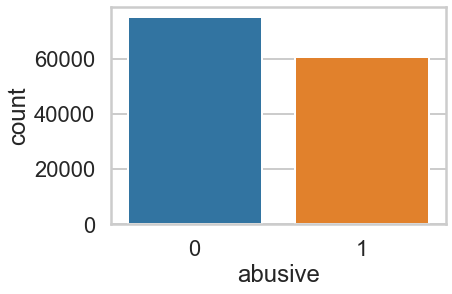

In [7]:
sns.countplot(x='abusive', data=df_text)

The binary classes look fairly well distributed, so we do not have to make any accommodations for under-represented classes

#### Now that the data is imported and appropriately formatted, we can begin on 
# Step 4 - Pre-processing Text

1. I am removing all special characters and differences of Case to get consistency when applying BoW Tf-idf vectorizer
2. Once cleaned, I drop the original 'text' column of uncleaned text

In [8]:
df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z ]', '')
df_text['clean_text'] = df_text['clean_text'].str.lower()
df_text.drop(columns=['text'], inplace=True)
df_text.head()

C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/1274324214.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z ]', '')
C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/1274324214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['clean_text'] = df_text['text'].str.replace('[^a-zA-Z ]', '')
C:\Users\DP185257\AppData\Local\Temp/ipykernel_10864/1274324214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

,hate_speech_score,abusive,clean_text
0,-3.90,0,yes indeed she sort of reminds me of the elder...
1,-6.52,0,the trans women reading this tweet right now i...
2,0.36,1,question these broads who criticize america w...
3,0.26,1,it is about time for all illegals to go back t...
4,1.54,1,for starters bend over the one in pink and kic...


### MEMORY CONSTRAINT
At this juncture, I have to reduce the size of the corpus for memory-related limitations

In [9]:
df_sm = df_text.sample(30000, ignore_index=True, random_state=123)
df_sm.head()

,hate_speech_score,abusive,clean_text
0,2.45,1,every slant in losangeles should be deported t...
1,0.05,1,lmfao me bumping a bitch that talks to my man
2,-3.30,0,latinas are the best
3,1.61,1,learn how to be a proper whore and show those ...
4,-4.80,0,nugs lauds ghanaian muslims for their immense ...


### Apply a TF-IDF vectorizer to get our Bag of Words / Vocabulary
Additionally, to remove irrelevant words and lower the vocabulary size, we are requiring words to appear in at least 10 (out of 30,000) tweets to be included in BoW. We are also dropping English "stop words"

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate TfidfVectorizer
tv = TfidfVectorizer(stop_words='english',
                    min_df=10)

# Fit the vectorizer and transform the data
tv_transformed = tv.fit_transform(df_sm['clean_text'])

# Create a DataFrame with these features
tv_df = pd.DataFrame(tv_transformed.toarray(), 
                     columns=tv.get_feature_names()).add_prefix('TFIDF_')
print(tv_df.head())

   TFIDF_abc  TFIDF_abeg  TFIDF_ability  TFIDF_able  TFIDF_abort  \
0        0.0         0.0            0.0         0.0          0.0   
1        0.0         0.0            0.0         0.0          0.0   
2        0.0         0.0            0.0         0.0          0.0   
3        0.0         0.0            0.0         0.0          0.0   
4        0.0         0.0            0.0         0.0          0.0   

   TFIDF_aborted  TFIDF_abortion  TFIDF_abortions  TFIDF_abraham  \
0            0.0             0.0              0.0            0.0   
1            0.0             0.0              0.0            0.0   
2            0.0             0.0              0.0            0.0   
3            0.0             0.0              0.0            0.0   
4            0.0             0.0              0.0            0.0   

   TFIDF_absolute  ...  TFIDF_youtube  TFIDF_youve  TFIDF_yr  TFIDF_yrs  \
0             0.0  ...            0.0          0.0       0.0        0.0   
1             0.0  ...          

This gives us 3674 'features', or words in our vocabulary

In [11]:
tv_df.shape

(30000, 3674)

Garbage cleanup of past 'weighty' variables in memory

In [12]:
 # manually initiate the garbage collector to remove the data from memory.
import gc
del df_text
gc.collect() 

0

# Step 5 - Modeling
### Model 1: Logistic Regression - Training and Scoring


In [13]:
from sklearn import linear_model, preprocessing
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.model_selection
from sklearn.model_selection import train_test_split

Split dataset into independent variables (TD-IDF BoW) and dependent variable (binary 'Abusive')

In [14]:
#Split data into X and y components
X_train, X_test, y_train, y_test = train_test_split(tv_df, df_sm.abusive, test_size=0.25, random_state=123)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(22500, 3674) (7500, 3674)
(22500,) (7500,)


Run a basic Logistic Regressor with C=10 and L2 Penalty and LibLinear resolver

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test)
y_prob = lr_tfidf.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_predict))


              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4100
           1       0.85      0.80      0.82      3400

    accuracy                           0.84      7500
   macro avg       0.85      0.84      0.84      7500
weighted avg       0.84      0.84      0.84      7500



This starts off already pretty good, with 84% accuracy and 88% positive Recall. 
<br>
Let's also plot heatmap of Confusion Matrix to get a better look

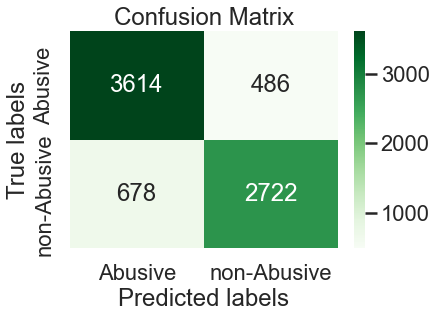

In [16]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Abusive', 'non-Abusive']); ax.yaxis.set_ticklabels(['Abusive', 'non-Abusive']);

#print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.9288244261119082


#### Initial assessment
Model performance isn't bad, with F1 score of 84% accuracy. However, in this problem of labeling text as 'Abusive' (positive class) or not, it should be more important to minimize the number of False Negatives (labeled as non-Abusive, when it actually is) aka Recall, than to minimize the number of False Positives (labeled as Abusive, when it really isn't) aka Precision. 
<br>
<br>
That said, let's fine tune the model to see if we can improve our overall accuracy, and then we can set out to see if we can achieve better recall with another Model

### Optimizing LogReg Hyperparameters
Using GridSearch, we will test 15 combinations of Solver + C values, using a constant Penalty=L2 hyperparam. 
The results from this indicated that the best params were solver=liblinear and C=10, which are the same hyperparamters we chose at the start, which is great, no change necessary

In [18]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['sag', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [50, 10, 1.0, 0.1, 0.05]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=123)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tv_df, df_sm.abusive)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.854011 using {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.847933 (0.004329) with: {'C': 50, 'penalty': 'l2', 'solver': 'sag'}
0.847656 (0.004362) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.847956 (0.004325) with: {'C': 50, 'penalty': 'l2', 'solver': 'liblinear'}
0.854011 (0.004255) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.853933 (0.004301) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.854000 (0.004294) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.852544 (0.004546) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
0.852556 (0.004582) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.852533 (0.004556) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.830744 (0.005304) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}
0.830733 (0.005317) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.830811 (0.005367) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.822767 (0.005834) with: {'C': 0.05, 'penalty': 'l2', 's

We don't see significant improvement with GridSearch, less than 0.02 points. Let's try another model to try and improve Recall
### Model 2: RandomForest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,log_loss

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 123,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.875
Random Forest: f1-score=0.874


In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4100
           1       0.89      0.82      0.86      3400

    accuracy                           0.87      7500
   macro avg       0.88      0.87      0.87      7500
weighted avg       0.88      0.87      0.87      7500



### Improvement via Random Forest
Immediately we see improvement over our LogReg model. We have an f1-score of 0.875, more than 2 points better than logReg, and our Recall is ~92%!
<br>
Let's check the Confusion Matrix and then see if we can improve that score with GridSearch tuning

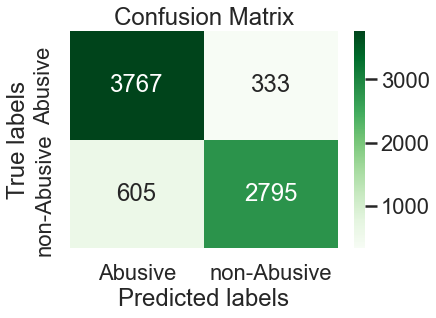

In [21]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Abusive', 'non-Abusive']); ax.yaxis.set_ticklabels(['Abusive', 'non-Abusive']);

#print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

### UPDATE: My box isn't adequate for multi-param CV GridSearch
The kernel would die after several hours without completing. Instead, below, is a series of single-param 'GridSearch' functions showing that the accuracy score improves as N_estimators increases, and that the Max_Features param seemed to be better suited for 'sqrt'.

In [26]:
import time

#### Starting with n_estimators=100 and max_features='sqrt'

In [34]:
model = RandomForestClassifier()
n_estimators = [100]
#, 50, 500
max_features = ['sqrt']
#, 'log2'
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=123)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tv_df, df_sm.abusive)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.872083 using {'max_features': 'sqrt', 'n_estimators': 100}
0.872083 (0.002237) with: {'max_features': 'sqrt', 'n_estimators': 100}


#### Using same n_estimators=100 but changing max_features='log2', we can see this underperformes the model above using ='sqrt'

In [35]:
model = RandomForestClassifier()
n_estimators = [100]
#, 50, 500
max_features = ['log2']
#, 'sqrt'
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=123)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(tv_df, df_sm.abusive)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.871133 using {'max_features': 'log2', 'n_estimators': 100}
0.871133 (0.002991) with: {'max_features': 'log2', 'n_estimators': 100}


#### Back to max_features='sqrt', and jump up to n_estimators=500, noted another minor improvement (+0.003), but in an overwritten trial, this was the same as n_estimators=300, so the model converges around ~300, which is what we already used in our initial RF Model

In [36]:
start = time.perf_counter()
model = RandomForestClassifier(n_estimators=500, max_depth=None, 
                               max_features='sqrt', n_jobs=-1,
                               random_state=123)
model.fit(tv_df, df_sm.abusive)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))
print('Random Forest: f1-score=%.3f' % (f1))

end = time.perf_counter()
print(end-start)

Random Forest: Accuracy=0.875
Random Forest: f1-score=0.874
243.98649959999602


With this model, we should be able to confidently identify Abusive Tweets (or any text articles), knowing we will correctly predict Abusive text 92% of the time. 

# Summary and Conclusions

Our dataset was too big to process entirely with current hardware specifications, so we used a subset of a very well annotated Twitter dataset. We confirmed there were no missing data points and no wild outliers that we didn't expect. 
<br><br>
We were able to process the text data to clean it up, lowercase everything, remove special characters, and then vectorize the cleaned text via TF IDF, to value important words higher. 
<br><br>
With the vectorized vocabulary, we trained both Logistic Regresion and Random Forest models. After optimizing hyperparameters in both cases, We found the Random Forest model confidently outperformed the Logistic Regression model, giving us an accuracy of 87.5% and Recall of 92%.
<br><br><br>